In [12]:

from scipy.stats import mode
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt
import pywt.data
import cv2
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

In [46]:
def pad(image, padding):
    padding = int(padding)
    if image.ndim == 2:
        w, h = image.shape
        result = np.zeros((w + padding * 2, h + padding * 2))
        result[padding:-padding, padding:-padding] = image
    if image.ndim == 3:
        c, w, h = image.shape
        result = np.zeros((c, w + padding * 2, h + padding * 2))
        result[:, padding:-padding, padding:-padding] = image
    return result


def activity_map2(c1, c2, kernel):
    kernel = int(kernel)
    p = int((kernel-1)/2)
    c1_p = pad(c1,p)
    c2_p = pad(c2,p)

    f=np.zeros((len(c1_p),len(c1_p[0])))

    for i in range(len(c1_p)):
        for j in range(len(c1_p[0])):
            w1 = c1_p[i:i+kernel-1, j:j+kernel-1]
            var1 = np.var(w1)
            var1_r = np.round(var1, decimals=0) # round variance 

            w2 = c2_p[i:i+kernel-1, j:j+kernel-1]
            var2 = np.var(w2)
            var2_r = np.round(var2, decimals=0)

            # np.abs(var1-var2)/(var1+0.0000001)

            if np.abs(var1-var2)/(var1+0.0000001) < 0.1: #if rounded variance is equal then average
                f[i,j] = int(np.mean( np.array([ w1, w2 ])))
            elif var1_r > var2_r:
                w1_max = np.amax(np.abs(w1))
                f[i,j] = w1_max
            elif var2_r > var1_r:
                w2_max = np.amax(np.abs(w2))
                f[i,j] = w2_max

            # if var1_r == var2_r: #if rounded variance is equal then average
            #     f[i,j] = int(np.mean( np.array([ w1, w2 ])))
            # elif var1_r > var2_r:
            #     w1_max = np.amax(np.abs(w1))
            #     f[i,j] = w1_max
            # elif var2_r > var1_r:
            #     w2_max = np.amax(np.abs(w2))
            #     f[i,j] = w2_max

            # print(var1,var1_r)
            # print(var2, var2_r)
            
    return f


from guided_filter_fuse import box_filter


def activity_map_fast(c, kernel):
    ones = np.ones(c.shape)
    N = box_filter(ones, radius)
    
    mu = box_filter(c, radius) / N
    var3 = box_filter(c * c, int((3-1)/2)) / N - mu * mu
    var5 = box_filter(c * c, int((5-1)/2)) / N - mu * mu
    
    output = np.zeros(c.shape)
    output = var3

    var5_greater = var5 > var3
    output[var5_greater] = var5[var5_greater]

    close = np.abs(var3 - var5) / (var3 + 0.0000001) < 0.1
    output[close] = (var3 + var5) / 2

    return output


def activity_map(c, kernel):
    p = int((5-1)/2)
    c_p = pad(c,p)
    f=np.zeros(c_p.shape)

    for i in range(len(c_p)):
        for j in range(len(c_p[0])):
            w1 = c_p[i:i+3-1, j:j+3-1]
            var1 = np.var(w1)

            w2 = c_p[i:i+5-1, j:j+5-1]
            var2 = np.var(w2)

            if np.abs(var1-var2)/(var1+0.0000001) < 0.1: #if rounded variance is equal then average
                f[i,j] = np.mean( np.concatenate([ w1.ravel(), w2.ravel() ]))
            else:
                f[i,j] = max(np.amax(np.abs(w1)), np.amax(np.abs(w2)))
            
    return f[p:-p, p:-p]

def max_map(c1, c2, kernel):  #just fuse based on max values
    kernel = int(kernel)
    p = int((kernel-1)/2)
    c1_p = pad(c1,p)
    c2_p = pad(c2,p)

    f = np.zeros(c1.shape)

    for i in range(len(c1)):
        for j in range(len(c1[0])):

            w1 = c1_p[:, i:i+kernel-1, j:j+kernel-1]
            w2 = c2_p[:, i:i+kernel-1, j:j+kernel-1]
            w1_max = np.amax(np.abs(w1))
            w2_max = np.amax(np.abs(w2))

            f[:, i, j] = w1_max > w2_max

    return f

def majority_filter(map, kernel):  #just fuse based on max values
    kernel = int(kernel)
    p = int((kernel-1)/2)
    map_p = pad(map, p)

    f = np.zeros(map.shape)

    c,w,h = map.shape

    for i in range(h):
        for j in range(w):
            w1 = map_p[:, j:j+kernel-1, i:i+kernel-1]
            f[:,j,i] = w1.sum((1,2)) > (h*w/2)

    return f

def fuse(c1, c2, kernel):
    binary_map = max_map(c1, c2, kernel)
    binary_map = 1 - majority_filter(1 - majority_filter(binary_map, kernel), kernel)
    binary_map = binary_map.astype(np.bool)

    c1[~binary_map] = 0
    c2[binary_map] = 0
    return c1 + c2

def conc(c1, c2, c3, c4):
    row1 = np.concatenate((c1,c2), axis = 1)
    row2 = np.concatenate((c3,c4), axis = 1)
    column = np.concatenate((row1,row2), axis = 0)
    return column


(205, 228) (3, 205, 228) (3, 205, 228) (3, 205, 228)
(103, 114) (3, 103, 114) (3, 103, 114) (3, 103, 114)
(52, 57) (3, 52, 57) (3, 52, 57) (3, 52, 57)
(26, 29) (3, 26, 29) (3, 26, 29) (3, 26, 29)
(13, 15) (3, 13, 15) (3, 13, 15) (3, 13, 15)
(7, 8) (3, 7, 8) (3, 7, 8) (3, 7, 8)
(4, 4) (3, 4, 4) (3, 4, 4) (3, 4, 4)
(3, 4, 4) (3, 4, 4) (3, 4, 4) (3, 4, 4)
(3, 7, 8) (3, 7, 8) (3, 7, 8) (3, 7, 8)
(3, 13, 15) (3, 13, 15) (3, 13, 15) (3, 13, 15)
(3, 26, 29) (3, 26, 29) (3, 26, 29) (3, 26, 29)
(3, 52, 57) (3, 52, 57) (3, 52, 57) (3, 52, 57)
(3, 103, 114) (3, 103, 114) (3, 103, 114) (3, 103, 114)
(3, 205, 228) (3, 205, 228) (3, 205, 228) (3, 205, 228)
0.0 22.828098897251845 255.0


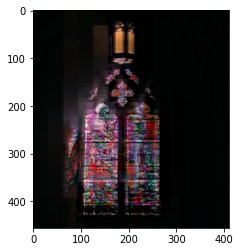

In [47]:
bf = np.asarray(Image.open('data/stained-glass-dark.png')).T
ff = np.asarray(Image.open('data/stained-glass-light.png')).T

# bf = cv2.imread('back.png', 0)
# ff = cv2.imread('front.png', 0)
# ff = np.delete(ff, (0), axis=0)


wavelet = 'haar'

x = bf
y = ff

stack = []

kernel_size = 3

while x.shape[-2:] > (2*kernel_size, 2*kernel_size):
    x, (hx, vx, dx) = pywt.dwt2(x, wavelet)
    y, (hy, vy, dy) = pywt.dwt2(y, wavelet)

    print(x.shape[-2:], hx.shape, vx.shape, dx.shape)

    stack.append(fuse(dx, dy, kernel=kernel_size))
    stack.append(fuse(vx, vy, kernel=kernel_size))
    stack.append(fuse(hx, hy, kernel=kernel_size))

    fused = fuse(x, y, kernel_size)

while len(stack) > 0:
    fused = resize(fused, stack[-1].shape)
    print(fused.shape, stack[-1].shape, stack[-2].shape, stack[-2].shape)
    fused = pywt.idwt2((fused, (stack.pop(-1), stack.pop(-1), stack.pop(-1))), wavelet)

fused = np.clip(fused, 0, 255)

print(fused.min(), fused.mean(), fused.max())

plt.imshow(fused.T/255)
plt.show()

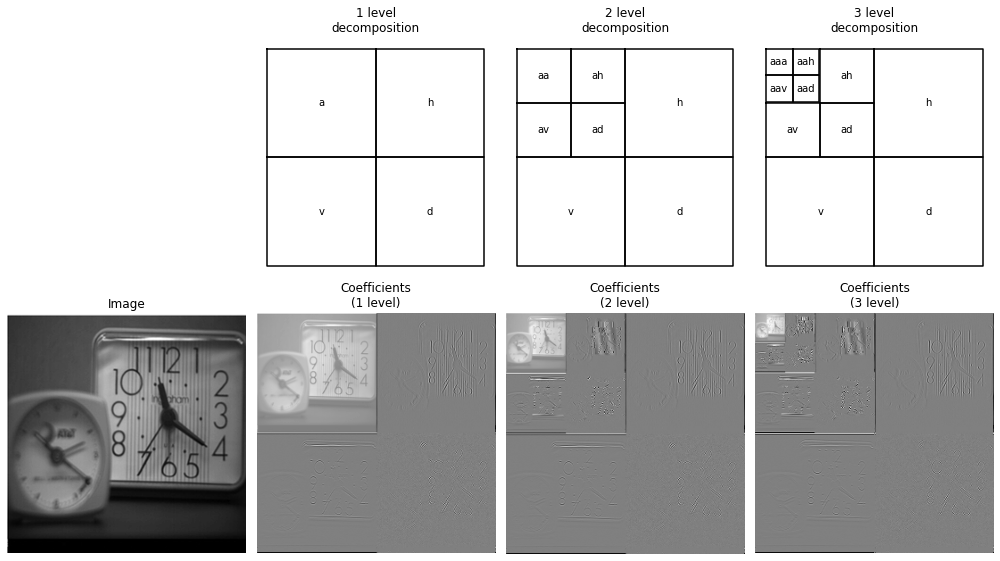

In [17]:
x1 = bf
shape = x1.shape

max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 4, figsize=[14, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x1, cmap=plt.cm.gray)
        axes[1, 0].set_title('Image')
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    # compute the 2D DWT
    c = pywt.wavedec2(x1, 'db2', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c)
    axes[1, level].imshow(arr, cmap=plt.cm.gray)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()
plt.show()

In [18]:
cc2 = fuse(c1,c2,3) # fuse images


In [19]:
im = Image.fromarray(cc2)
im.show(im)


In [20]:
temp = cc2 
cc2 = unpad(cc2,3) #unpad fused image


In [21]:
ccA1 = cc2[0:len(cA1), 0:len(cA1[0])]
ccH1 = cc2[0:len(cA1), len(cA1[0]):len(cA1[0])*2]
ccV1 = cc2[len(cA1):len(cA1)*2, 0:len(cA1[0])]
ccD1 = cc2[len(cA1):len(cA1)*2, len(cA1[0]):len(cA1[0])*2]


In [22]:
ccoeff = ccA1, (ccH1, ccV1, ccD1)
inverse_fused = pywt.idwt2(ccoeff, wavelet)
im = Image.fromarray(inverse_fused)
im.show(im)
im = Image.fromarray(bf)
im.show(im)
im = Image.fromarray(ff)
im.show(im)

In [23]:

ctA = fuse(cA1,cA2,3)
ctH = fuse(cH1,cH2,3)
ctV = fuse(cV1,cV2,3)
ctD = fuse(cD1,cD2,3)

In [24]:
ctA = unpad(ctA,3)
ctH = unpad(ctH,3)
ctV = unpad(ctV,3)
ctD = unpad(ctD,3)

In [25]:
ctoeff = ctA, (ctH, ctV, ctD)
tinverse_fused = pywt.idwt2(ctoeff, wavelet)
im = Image.fromarray(tinverse_fused)
im.show(im)
im = Image.fromarray(bf)
im.show(im)
im = Image.fromarray(ff)
im.show(im)